# Simulation


## 1. Simulate data according to the proposed model.

In [83]:
%pip install numpy matplotlib scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [106]:
# Defining eta function (could be linear, quasratic, constant, sinus, etc)

def eta_linear_bis(x: np.ndarray, eta_max) -> np.ndarray:
    """Linear noise: η(x) = η_max * (eta_max + 0.4*(x+1)/2)"""
    x_flat = x if x.ndim == 1 else np.mean(x, axis=1)
    return eta_max * (eta_max +  (np.abs(x_flat))/20)

def eta_linear(x: np.ndarray, eta_max) -> np.ndarray:
    """Linear noise: η(x) = η_max * (eta_max + 0.4*(x+1)/2)"""
    x_flat = x if x.ndim == 1 else np.mean(x, axis=1)
    return eta_max * (eta_max + 0.4 * (x_flat + 1) / 2)

In [107]:
# Generate data
def generate_data(m: int, d: int, eta_func, eta_max: float = 0.8):
    # Generate X uniformly in [-1, 1]^d
    X = np.random.uniform(-1, 1, size=(m, d))
    
    # Generate true labels Y uniformly from {-1, +1}
    Y = np.array([], dtype=int)
    for i in range(m):
        n = np.random.rand()
        if n < 0.8 :
            Y = np.append(Y,1)
        else:
            Y = np.append(Y,-1)
    Y.reshape(m,)

    # Compute true noise levels
    eta_true = eta_func(X, eta_max)
    
    # Generate corrupted labels Z
    Z = np.zeros(m,  dtype=np.int_)
    for i in range(m):
        # Flip label with probability η(X_i)
        if np.random.rand() < eta_true[i]:
            Z[i] = -Y[i]  # Flip
        else:
            Z[i] = Y[i]   # Keep
    
    return X, Y, Z, eta_true

In [108]:
# Test
eta_max=0.5
N = 10
m = 5000
d = 1
X, Y, Z, eta_true = generate_data(m, d, eta_linear, eta_max=0.3)

print(f"Generated {m} samples in dimension d={d}")
print(f"X shape: {X.shape}")
print(f"Y values: {np.unique(Y)} (counts: {np.bincount((Y+1)//2)})")
print(f"Z values: {np.unique(Z)} (counts: {np.bincount((Z+1)//2)})")
print(f"Empirical flip rate: {np.mean(Y != Z):.3f}")
print(f"True average η: {np.mean(eta_true):.3f}")


Generated 5000 samples in dimension d=1
X shape: (5000, 1)
Y values: [-1  1] (counts: [ 963 4037])
Z values: [-1  1] (counts: [1393 3607])
Empirical flip rate: 0.148
True average η: 0.150


## 2. Implement the estimator of η that you proposed.

In [109]:
def gaussian_kernel (u,d,h):
    """Has to be symmetrical"""
    factor = (2*np.pi)**(-d/2)
    return(factor * np.exp(-np.dot(u,u)/2))


In [110]:
def eta_estimator(X,Z,x,h):
    eta_tilde = 0
    denominator = 0
    d = X.shape[1]
    for i in range(len(X)):
        K = gaussian_kernel((X[i]-x)/h,d,h)
        eta_tilde += (1-Z[i])*K
        denominator += K

    eta_tilde = eta_tilde/(2*denominator)
    return(eta_tilde)


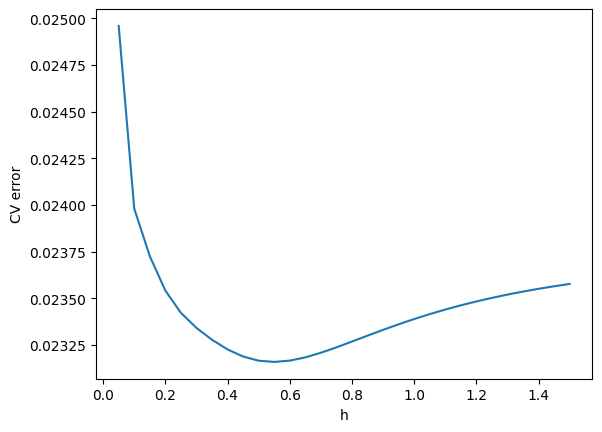

In [ ]:
# Cross-validation to chose h

def cross_validation(eta,X,Z,h):
    error = 0

    for i in range(X.shape[0]):
            cross_X = np.delete(X,i,0)
            cross_Z = np.delete(Z,i,0)
            error+= (eta[i] - eta_estimator(cross_X,cross_Z,X[i],h))**2
    
    return((1/X.shape[0])*error)

hs = np.linspace(0.05, 1.50, 30)
errs = [cross_validation(eta_true,X, Z, h) for h in hs]

plt.plot(hs, errs)
plt.xlabel("h")
plt.ylabel("CV error")

    

In [ ]:
# optimal_h = 0
# min_error = np.inf
# for h in  np.linspace(0.1,1.5,30):
#       error = cross_validation(eta_true,X,Z,h)
#       if error < min_error :
#             optimal_h = h
#             min_error = error

# print(optimal_h)

0.5344827586206896


In [126]:
X_test, Y_test, Z_test, eta_true = generate_data(1,d,eta_linear,eta_max=0.5)
for x in X_test :
    estimated_eta = eta_estimator(X,Z,x,0.5344827586206896)

print(f"Estimated value of eta {estimated_eta}")
print(f"Real value of eta : {eta_true}")

Estimated value of eta 0.2831822709743712
Real value of eta : [0.36652019]


## 3. Illustrate empirically its performance (estimation error, influence of the sample size m, the dimension d, and the noise level).